In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

This notebook reads CSV United Nations population tables and produces an xarray Dataset to be read by the AgriFoodPy package when importing the population modules.

``` python
from agrifoodpy.population.population import UN
```

The dimension coordinates of the array are
- **Year**
- **Region code**
- Region name
- **Datatype**

In bold, the coordinates used to index the array. The *Region name* coordinate is for easy labelling and identification of regions. 

The original CSV file read in this notebook can be obtained here: https://population.un.org/wpp/Download/Standard/CSV/

after accessing the **Total Population** Sub Group file:
https://population.un.org/wpp/Download/Files/1_Indicators%20(Standard)/CSV_FILES/WPP2022_TotalPopulationBySex.csv

Population estimates are separated into 9 different *variants* for different combinations of fertility, mortality and international migration, which has different effects on different regions but cancels out at the *world* level.

- Medium
- High
- Low
- Constant fertility
- Instant replacement
- Zero migration
- Constant mortality
- No change
- Momentum
- Instant replacement zero migration

Additionally, uncertainty values are given for the Medium projection

- Median PI
- Upper 80 PI
- Lower 80 PI
- Upper 95 PI
- Lower 95 PI

In [2]:
# Last published year 
year = 2022

In [3]:
pop = pd.read_csv(f'../data/population/WPP{year}_TotalPopulationBySex.csv')
pop.head()

/tmp/ipykernel_350075/2773614349.py:1: DtypeWarning: Columns (2,3,4,7) have mixed types. Specify dtype option on import or set low_memory=False.
  pop = pd.read_csv(f'../data/population/WPP{year}_TotalPopulationBySex.csv')


,SortOrder,LocID,Notes,ISO3_code,ISO2_code,SDMX_code,LocTypeID,LocTypeName,ParentID,Location,VarID,Variant,Time,MidPeriod,PopMale,PopFemale,PopTotal,PopDensity
0,NaN,1857,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AUKUS,2,Medium,1950,1950.5,101683.967,104829.814,206513.782,12.096
1,NaN,1857,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AUKUS,2,Medium,1951,1951.5,103204.345,106085.841,209290.187,12.259
2,NaN,1857,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AUKUS,2,Medium,1952,1952.5,104727.488,107331.845,212059.333,12.421
3,NaN,1857,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AUKUS,2,Medium,1953,1953.5,106093.466,108905.518,214998.984,12.593
4,NaN,1857,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AUKUS,2,Medium,1954,1954.5,107669.185,110509.997,218179.182,12.779


## Region and subregions

Data for regions and geographic regions is provided in the dataset. Using the "ParentID" column we can track back to the each parent region.

For some reason, Canada, USA, Greenland, Saint Pierre and Miquelon, and Bermuda in Northern America are not assined to their respective region when tracking the ParentID column
We assign these manually.

In [4]:
loc_ID = pop["LocID"].unique()
loc_name = []
loc_type = []
loc_subr = []
loc_regn = []

def find_loc_name(ID):
    lname = pop[pop["LocID"]==ID]["Location"].iloc[0]
    ltype = pop[pop["LocID"]==ID]["LocTypeName"].iloc[0]
    p_id = pop[pop["LocID"]==ID]["ParentID"].iloc[0]
    
    return lname, ltype, p_id

for id in loc_ID:
    lname, ltype, p_id = find_loc_name(id)
    loc_name.append(lname)
    loc_type.append(ltype)
    
    if np.isnan(p_id):
        loc_subr.append(np.nan)
        loc_regn.append(np.nan)
        continue
    
    try:
        p_name, _, p_p_id,=  find_loc_name(p_id)
    except IndexError:
        loc_subr.append(np.nan)
        loc_regn.append(np.nan)
        continue
        
    loc_subr.append(p_name)
    try:
        p_p_name = find_loc_name(p_p_id)[0]
    except IndexError:
        loc_regn.append(np.nan)
        continue
    loc_regn.append(p_p_name)

In [5]:
mask = np.where(np.isin(loc_ID, [124, 60, 840, 304, 666]))[0]
for index in mask:
    loc_regn[index] = "Northern America"
    loc_subr[index] = "Northern America"

In [6]:
for ir in range(len(loc_ID)):
    print(loc_ID[ir], loc_name[ir], loc_type[ir], loc_subr[ir], loc_regn[ir])

1857 AUKUS nan nan nan
1823 African Group nan nan nan
1560 African Union nan nan nan
2080 African Union: Central Africa nan nan nan
2081 African Union: Eastern Africa nan nan nan
2082 African Union: Northern Africa nan nan nan
2083 African Union: Southern Africa nan nan nan
2084 African Union: Western Africa nan nan nan
1200 African, Caribbean and Pacific (ACP) Group of States nan nan nan
1533 Andean Community nan nan nan
1207 Asia-Pacific Economic Cooperation (APEC) nan nan nan
1824 Asia-Pacific Group nan nan nan
1557 Association of Southeast Asian Nations (ASEAN) nan nan nan
1525 BRIC nan nan nan
1526 BRICS nan nan nan
2067 Belt-Road Initiative (BRI) nan nan nan
2068 Belt-Road Initiative: Africa nan nan nan
2069 Belt-Road Initiative: Asia nan nan nan
2070 Belt-Road Initiative: Europe nan nan nan
2071 Belt-Road Initiative: Latin America and the Caribbean nan nan nan
2072 Belt-Road Initiative: Pacific nan nan nan
1527 Black Sea Economic Cooperation (BSEC) nan nan nan
1569 Bolivarian Al

In [7]:
years = pd.unique(pop["Time"])
variants = pd.unique(pop["Variant"])
datatypes = ["Total", "Male", "Female", "Density"] 

# Some numpy trickery to get the indices for the area, elements and items
iy = np.nonzero(pop['Time'].to_numpy()[:, None] == years)[1]
il = np.nonzero(pop['LocID'].to_numpy()[:, None] == loc_ID)[1]
iv = np.nonzero(pop['Variant'].to_numpy()[:, None] == variants)[1]

# We compute the index in the flattened array
ipos = iy * len(loc_ID) * len(variants) + il * len(variants) + iv
        
ipos = ipos.astype(int)

In [8]:
pop_total = np.ones(len(years)*len(loc_ID)*len(variants))*np.NaN
pop_male = np.ones(len(years)*len(loc_ID)*len(variants))*np.NaN
pop_female = np.ones(len(years)*len(loc_ID)*len(variants))*np.NaN
pop_dens = np.ones(len(years)*len(loc_ID)*len(variants))*np.NaN

pop_total[ipos] = pop['PopTotal']
pop_female[ipos] = pop['PopFemale']
pop_male[ipos] = pop['PopMale']
pop_dens[ipos] = pop['PopDensity']

pop_total = pop_total.reshape(len(years), len(loc_ID), len(variants))
pop_female = pop_female.reshape(len(years), len(loc_ID), len(variants))
pop_male = pop_male.reshape(len(years), len(loc_ID), len(variants))
pop_dens = pop_dens.reshape(len(years), len(loc_ID), len(variants))

pop_arr = np.ones((len(years), len(loc_ID), len(variants), len(datatypes)))

for idt, data_arr in enumerate([pop_total, pop_female, pop_male, pop_dens]):
    pop_arr[...,idt] = data_arr 

In [9]:
pop[pop["Location"]=="United States of America"]

,SortOrder,LocID,Notes,ISO3_code,ISO2_code,SDMX_code,LocTypeID,LocTypeName,ParentID,Location,VarID,Variant,Time,MidPeriod,PopMale,PopFemale,PopTotal,PopDensity
514413,262.0,840,31.0,USA,US,840.0,4.0,Country/Area,918.0,United States of America,2,Medium,1950,1950.5,73516.095,74765.455,148281.550,16.210
514414,262.0,840,31.0,USA,US,840.0,4.0,Country/Area,918.0,United States of America,2,Medium,1951,1951.5,74784.499,75813.955,150598.453,16.463
514415,262.0,840,31.0,USA,US,840.0,4.0,Country/Area,918.0,United States of America,2,Medium,1952,1952.5,76079.283,76862.444,152941.727,16.719
514416,262.0,840,31.0,USA,US,840.0,4.0,Country/Area,918.0,United States of America,2,Medium,1953,1953.5,77221.443,78229.756,155451.199,16.994
514417,262.0,840,31.0,USA,US,840.0,4.0,Country/Area,918.0,United States of America,2,Medium,1954,1954.5,78577.893,79627.980,158205.873,17.295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515665,262.0,840,31.0,USA,US,840.0,4.0,Country/Area,918.0,United States of America,207,Lower 95 PI,2096,2096.5,147409.224,150282.115,299545.109,32.746
515666,262.0,840,31.0,USA,US,840.0,4.0,Country/Area,918.0,United States of America,207,Lower 95 PI,2097,2097.5,146497.408,149522.313,297876.458,32.563
515667,262.0,840,31.0,USA,US,840.0,4.0,Country/Area,918.0,United States of America,207,Lower 95 PI,2098,2098.5,145646.516,148670.814,295844.406,32.341
515668,262.0,840,31.0,USA,US,840.0,4.0,Country/Area,918.0,United States of America,207,Lower 95 PI,2099,2099.5,145047.307,147555.848,293706.699,32.108


In [10]:
data = xr.Dataset(
    coords = dict(
        Year=("Year", years),
        Region=("Region", loc_ID),
        Region_name=("Region", loc_name),
        Region_type=("Region", loc_type),
        Region_subregion=("Region", loc_subr),
        Region_region=("Region", loc_regn),
        Datatype=("Datatype", datatypes)
    )
)

for iv, variant in enumerate(variants):
    data = data.assign({variant:(["Year", "Region", "Datatype"], pop_arr[:,:,iv,:])})

In [11]:
# Checking the coordinates of North American regions

# Canada: 124
# Bermuda: 60
# United States of America: 840
# Greenland: 304
# Saint Pierre and Miquelon: 666

data.sel(Region=[124, 60, 840, 304, 666])

<xarray.Dataset>
Dimensions:                             (Year: 151, Region: 5, Datatype: 4)
Coordinates:
  * Year                                (Year) int64 1950 1951 ... 2099 2100
  * Region                              (Region) int64 124 60 840 304 666
    Region_name                         (Region) <U93 'Canada' ... 'Saint Pie...
    Region_type                         (Region) <U32 'Country/Area' ... 'Cou...
    Region_subregion                    (Region) <U32 'Northern America' ... ...
    Region_region                       (Region) <U32 'Northern America' ... ...
  * Datatype                            (Datatype) <U7 'Total' ... 'Density'
Data variables: (12/15)
    Medium                              (Year, Region, Datatype) float64 1.37...
    High                                (Year, Region, Datatype) float64 nan ...
    Low                                 (Year, Region, Datatype) float64 nan ...
    Constant fertility                  (Year, Region, Datatype) float64 nan ...
    Instant replacement                 (Year, Region, Datatype) float64 nan ...
    Zero migration                      (Year, Region, Datatype) float64 nan ...
    ...                                  ...
    Instant replacement zero migration  (Year, Region, Datatype) float64 nan ...
    Median PI                           (Year, Region, Datatype) float64 nan ...
    Upper 80 PI                         (Year, Region, Datatype) float64 nan ...
    Lower 80 PI                         (Year, Region, Datatype) float64 nan ...
    Upper 95 PI                         (Year, Region, Datatype) float64 nan ...
    Lower 95 PI                         (Year, Region, Datatype) float64 nan ...

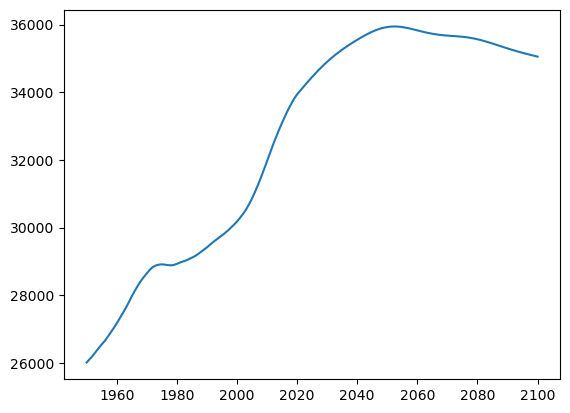

In [12]:
plt.plot(data.Year.values, data.Medium.sel(Region=data.Region_name=="United Kingdom", Datatype="Male"))

In [13]:
encoding = {}

for variant in variants:
    encoding[variant] = {"dtype":"float32", "zlib": True, "complevel": 5}

data.to_netcdf("data/UN.nc", encoding = encoding)